<a href="https://colab.research.google.com/github/jayrom/enterprise_challenge_reply/blob/main/sprint_4/src/reply_4_modeling_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise e modelagem para predição de eventos de manutenção

Este notebook realiza o processo completo de análise, pré-processamento e treinamento de modelos de Machine Learning para predição de falhas em equipamentos industriais.

**Objetivos**
1. **Análise exploratória (EDA)** - Entender as características e relações nos dados dos sensores.
2.  **Engenharia de features** - Extrair informações adicionais do `timestamp` para enriquecer o modelo.
3.  **Treinamento de modelos**
    * **Regressão** - Prever os "dias para a falha" (`days_to_failure`).
    * **Classificação** - Identificar o "modo de falha" (`failure_mode`).
4.  **Avaliação** - Medir a performance dos modelos de forma robusta e confiável.
5.  **Exportação** - Salvar os modelos e artefatos treinados para uso em produção.

**Workflow**

0. Carregar o dataset para o ambiente do Colab.
1. Importar bibliotecas e carregar os dados.
2. Realizar a análise exploratória.
3. Pré-processar os dados e criar novas features.
4. Dividir os dados para treino e teste (de forma cronológica).
5. Treinar e avaliar os modelos.
6. Salvar os artefatos finais.

## 0 - Carregar dataset

Ao executar o código a seguir, um botão será exibido solicitando o upload do seu arquivo `train_dataset_complex.csv`.

In [ ]:
from google.colab import files
import io

print("Por favor, faça o upload do arquivo 'train_dataset_complex.csv'")
uploaded = files.upload()

# Pega o nome do arquivo que foi feito o upload
file_name = list(uploaded.keys())[0]
print(f"\nArquivo '{file_name}' carregado com sucesso!")

Por favor, faça o upload do arquivo 'train_simulated_sensor_data.csv'


Saving training_dataset_complex.csv to training_dataset_complex.csv

Arquivo 'training_dataset_complex.csv' carregado com sucesso!


## 1. Configuração Inicial

In [ ]:
# 1.1. Importação de bibliotecas
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Métricas e pré-processamento
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
# 1.2. Carregamento dos dados
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# Converter a coluna 'timestamp' para o tipo datetime e ordenar
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp').reset_index(drop=True)

print("Dataset carregado e ordenado. Exibindo as 5 primeiras linhas:")
df.head()

Dataset carregado e ordenado. Exibindo as 5 primeiras linhas:


,timestamp,device_id,temperature_c,current_amps,vibration_magnitude_mss,days_to_failure,failure_mode
0,2024-01-01 00:00:00,motor_A,31.99,1.44,9.79,0.0,normal
1,2024-01-01 00:10:00,motor_A,30.72,1.54,9.87,0.0,normal
2,2024-01-01 00:20:00,motor_A,32.30,1.60,9.77,0.0,normal
3,2024-01-01 00:30:00,motor_A,34.05,1.60,9.76,0.0,normal
4,2024-01-01 00:40:00,motor_A,30.53,1.55,9.78,0.0,normal


## 2. Análise exploratória de dados (EDA)

In [ ]:
# 2.1. Informações básicas
print("Informações gerais do dataset:")
df.info()

print("\nEstatísticas descritivas:")
df.describe()

Informações Gerais do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2750 entries, 0 to 2749
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   timestamp                2750 non-null   datetime64[ns]
 1   device_id                2750 non-null   object        
 2   temperature_c            2750 non-null   float64       
 3   current_amps             2750 non-null   float64       
 4   vibration_magnitude_mss  2750 non-null   float64       
 5   days_to_failure          2750 non-null   float64       
 6   failure_mode             2750 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 150.5+ KB

Estatísticas Descritivas:


,timestamp,temperature_c,current_amps,vibration_magnitude_mss,days_to_failure
count,2750,2750.000000,2750.000000,2750.000000,2750.000000
mean,2024-01-10 13:05:00,33.197840,2.362895,10.141840,0.277836
min,2024-01-01 00:00:00,23.620000,0.820000,9.610000,0.000000
25%,2024-01-05 18:32:30,30.100000,1.550000,9.780000,0.000000
50%,2024-01-10 13:05:00,31.835000,1.650000,9.830000,0.000000
75%,2024-01-15 07:37:30,34.507500,2.067500,9.990000,0.280000
max,2024-01-20 02:10:00,52.540000,7.950000,15.740000,2.490000
std,NaN,4.756579,1.485669,0.924591,0.552501


Número de dados duplicados: 0


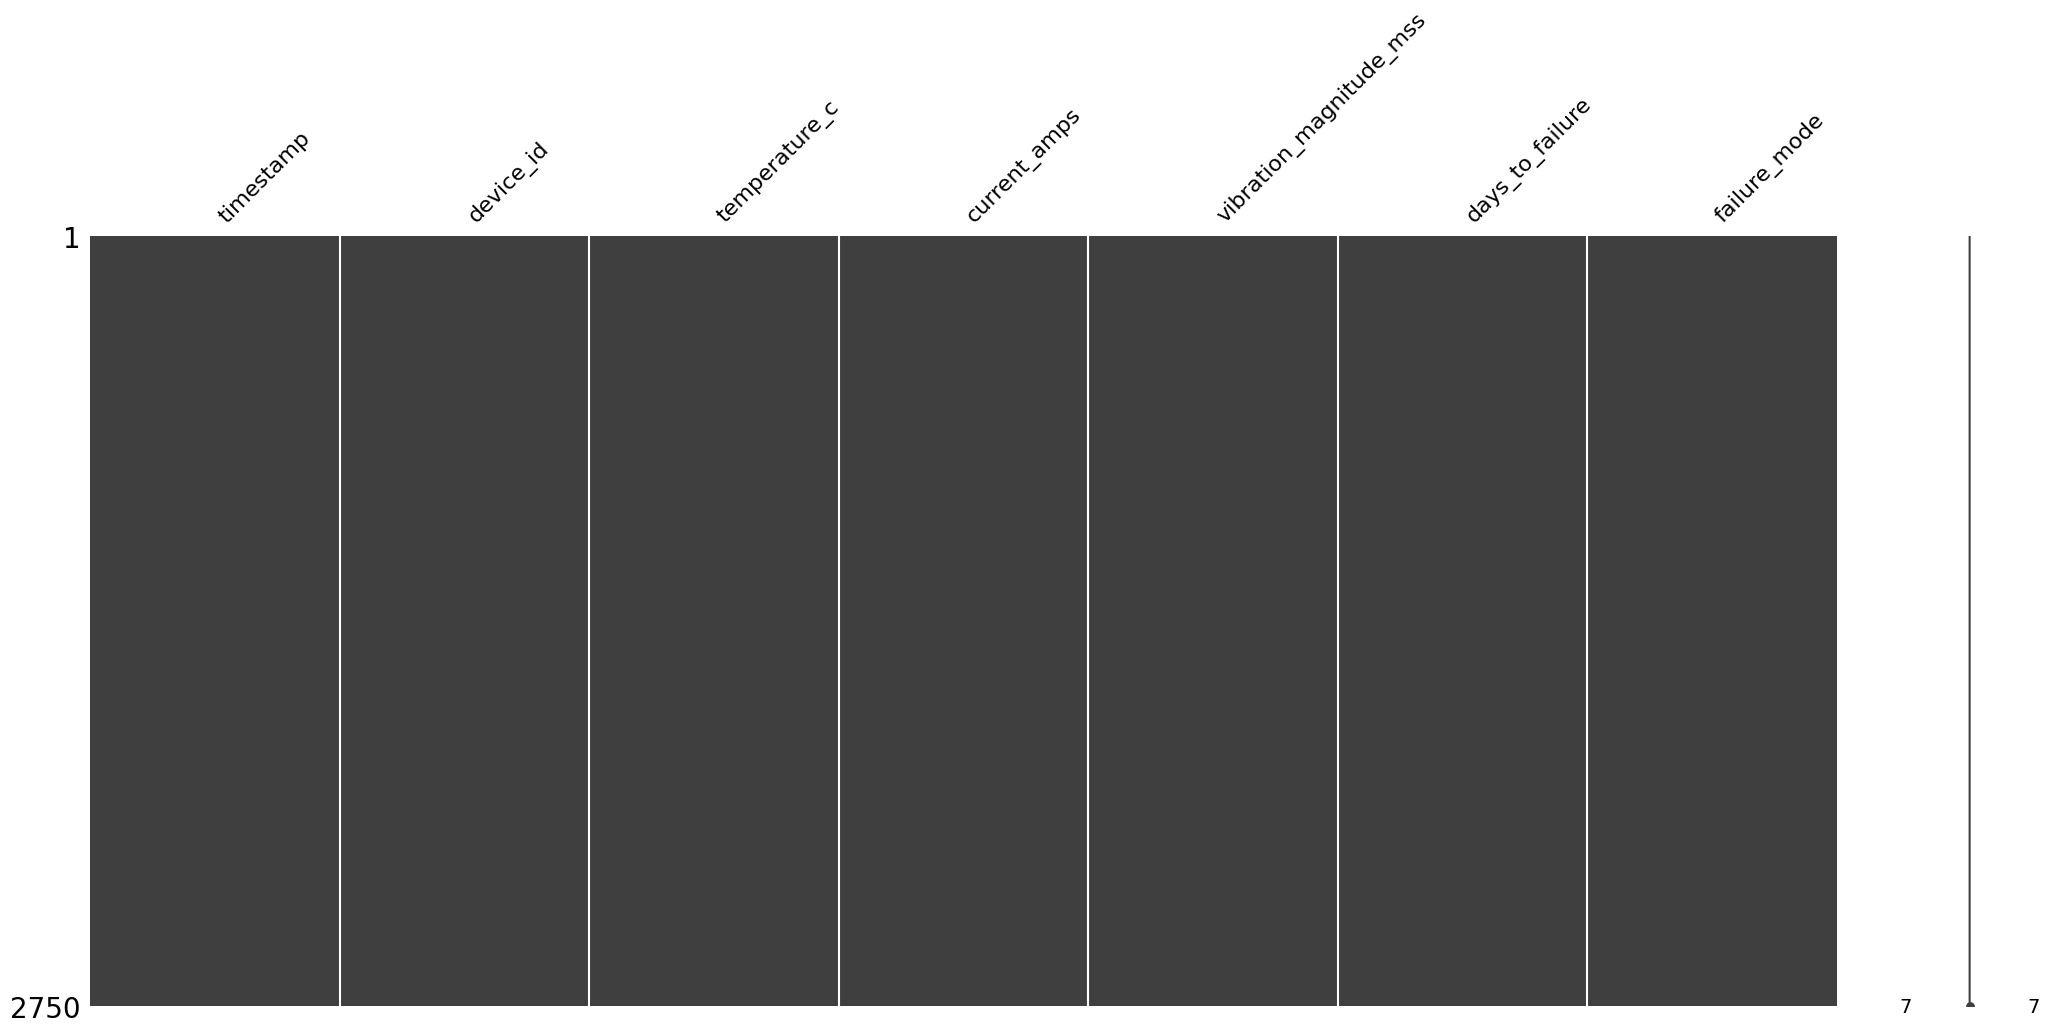

In [ ]:
# 2.2. Verificação de dados faltantes e duplicados
print(f"Número de dados duplicados: {df.duplicated().sum()}")
df = df.drop_duplicates()

# Visualização de dados faltantes
import missingno as msno
msno.matrix(df);

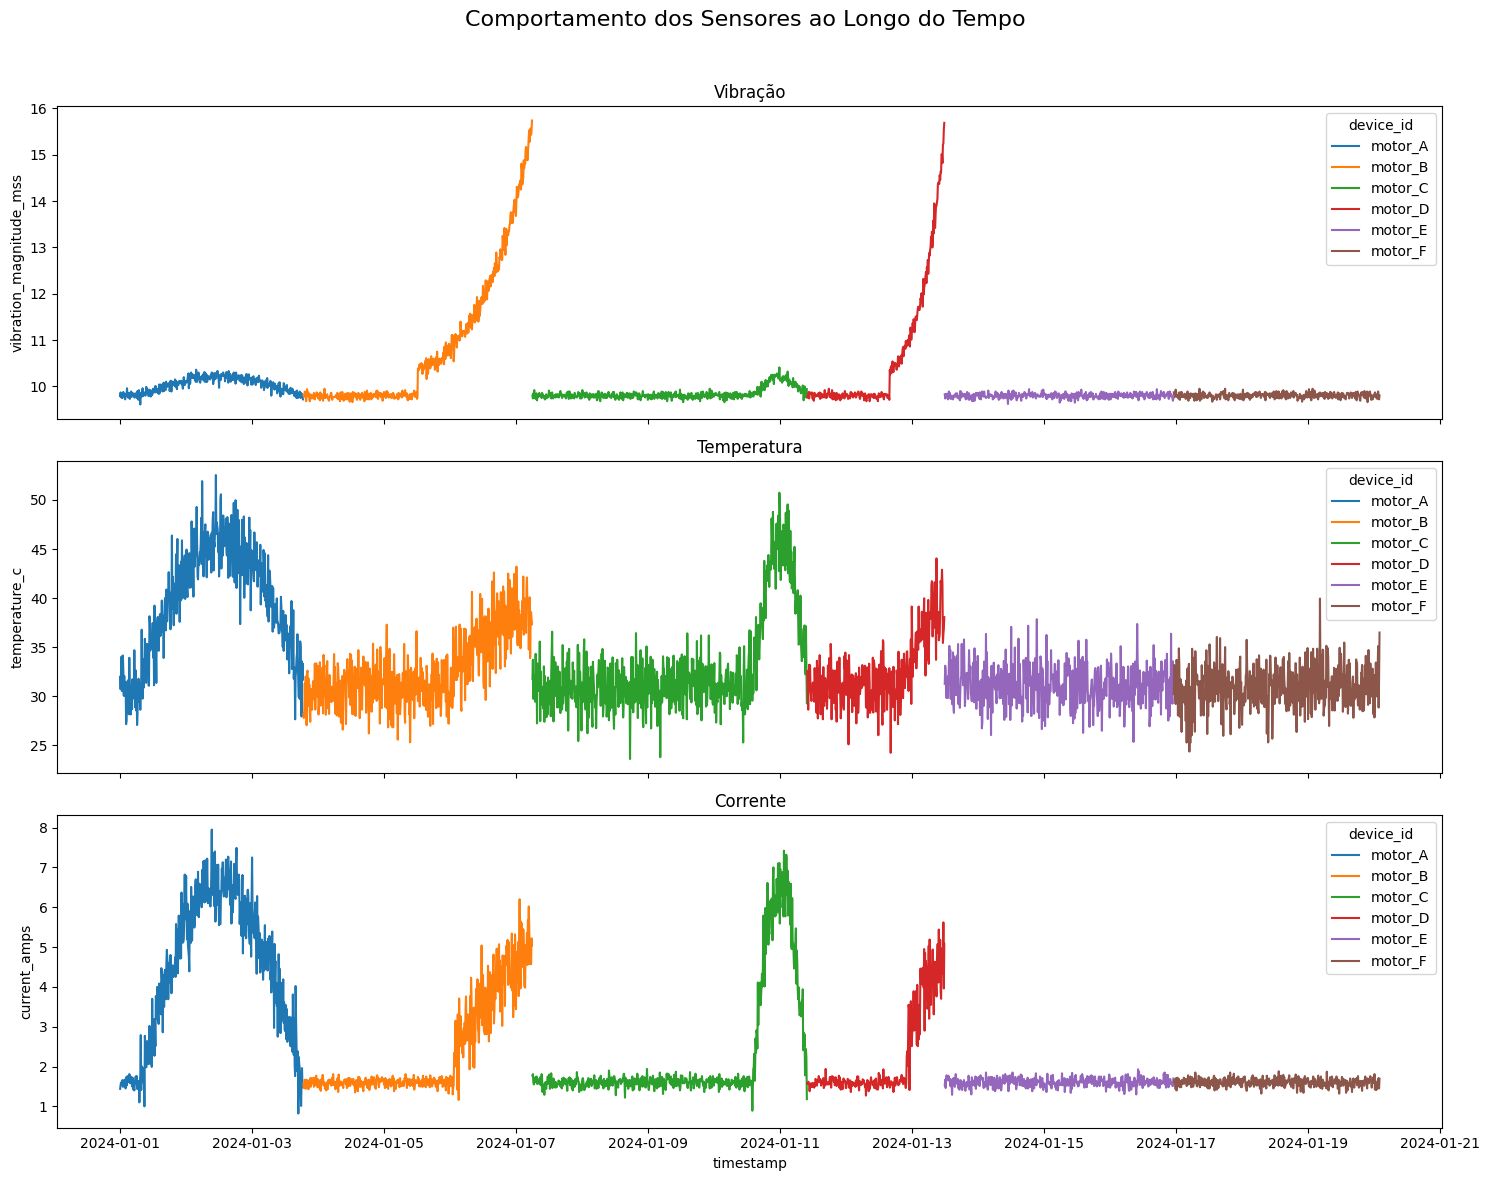

In [ ]:
# 2.3. Comportamento dos sensores ao longo do tempo
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12), sharex=True)
sns.lineplot(data=df, x='timestamp', y='vibration_magnitude_mss', hue='device_id', ax=axes[0])
sns.lineplot(data=df, x='timestamp', y='temperature_c', hue='device_id', ax=axes[1])
sns.lineplot(data=df, x='timestamp', y='current_amps', hue='device_id', ax=axes[2])

axes[0].set_title('Vibração')
axes[1].set_title('Temperatura')
axes[2].set_title('Corrente')
fig.suptitle('Comportamento dos sensores ao longo do tempo', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

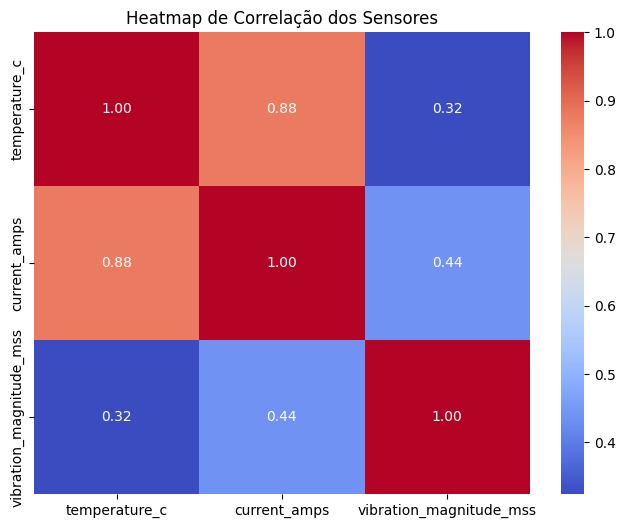

In [ ]:
# 2.4. Matriz de correlação entre as features numéricas
correlation_matrix = df[['temperature_c', 'current_amps', 'vibration_magnitude_mss']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de correlação entre features')
plt.show()

## 3. Pré-processamento e engenharia de features

In [ ]:
# 3.1. Engenharia de features temporais
print("Iniciando a engenharia de features a partir do timestamp...")

df['hora_do_dia'] = df['timestamp'].dt.hour
df['dia_da_semana'] = df['timestamp'].dt.dayofweek
df['hora_sin'] = np.sin(2 * np.pi * df['hora_do_dia'] / 24.0)
df['hora_cos'] = np.cos(2 * np.pi * df['hora_do_dia'] / 24.0)
df['dia_semana_sin'] = np.sin(2 * np.pi * df['dia_da_semana'] / 7.0)
df['dia_semana_cos'] = np.cos(2 * np.pi * df['dia_da_semana'] / 7.0)

print("Features temporais (hora_sin/cos, dia_semana_sin/cos) criadas.")

# 3.2. Codificação de variáveis categóricas
df_encoded = pd.get_dummies(df, columns=['device_id'], prefix='device', drop_first=True)
print("Feature 'device_id' codificada.")
df_encoded.head()

Iniciando a engenharia de features a partir do timestamp...
Features temporais (hora_sin/cos, dia_semana_sin/cos) criadas.
Feature 'device_id' codificada.


,timestamp,temperature_c,current_amps,vibration_magnitude_mss,days_to_failure,failure_mode,hora_do_dia,dia_da_semana,hora_sin,hora_cos,dia_semana_sin,dia_semana_cos,device_motor_B,device_motor_C,device_motor_D,device_motor_E,device_motor_F
0,2024-01-01 00:00:00,31.99,1.44,9.79,0.0,normal,0,0,0.0,1.0,0.0,1.0,False,False,False,False,False
1,2024-01-01 00:10:00,30.72,1.54,9.87,0.0,normal,0,0,0.0,1.0,0.0,1.0,False,False,False,False,False
2,2024-01-01 00:20:00,32.30,1.60,9.77,0.0,normal,0,0,0.0,1.0,0.0,1.0,False,False,False,False,False
3,2024-01-01 00:30:00,34.05,1.60,9.76,0.0,normal,0,0,0.0,1.0,0.0,1.0,False,False,False,False,False
4,2024-01-01 00:40:00,30.53,1.55,9.78,0.0,normal,0,0,0.0,1.0,0.0,1.0,False,False,False,False,False


## 4. Preparação para modelagem

In [ ]:
# 4.1. Definição de features (X) e targets (y)
features = [
    'temperature_c', 'current_amps', 'vibration_magnitude_mss',
    'device_motor_B', 'hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos'
]
X = df_encoded[features]

# Target para regressão
y_reg = df_encoded['days_to_failure']

# Target para classificação
le = LabelEncoder()
y_class = le.fit_transform(df_encoded['failure_mode'])

print(f"Features selecionadas para o modelo: {features}")
print(f"Alvos de classificação codificados: {list(le.classes_)} -> {le.transform(le.classes_)}")

Features selecionadas para o modelo: ['temperature_c', 'current_amps', 'vibration_magnitude_mss', 'device_motor_B', 'hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos']
Alvos de classificação codificados: ['desbalanceamento', 'desgaste_rolamento', 'normal'] -> [0 1 2]


In [ ]:
# 4.2. Divisão treino-teste com estratificação
print("Dividindo os dados em treino e teste de forma estratificada...")

# Em vez da divisão cronológica, usamos a divisão aleatória estratificada, para garantir que o conjunto de teste tenha todas as classes de falha para uma avaliação completa.
# O 'stratify=y_class' mantém a mesma proporção de cada classe nos conjuntos de treino e teste.
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.3, random_state=42, stratify=y_class
)

X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_class, test_size=0.3, random_state=42, stratify=y_class
)


print(f"Tamanho do conjunto de treino: {len(X_train)} registros")
print(f"Tamanho do conjunto de teste: {len(X_test)} registros")

print("\nDistribuição das classes no conjunto de TREINO:")
print(pd.Series(y_train_class).value_counts(normalize=True).round(2))

print("\nDistribuição das classes no conjunto de TESTE:")
print(pd.Series(y_test_class).value_counts(normalize=True).round(2))

Dividindo os dados em treino e teste de forma estratificada...
Tamanho do conjunto de treino: 1925 registros
Tamanho do conjunto de teste: 825 registros

Distribuição das classes no conjunto de TREINO:
2    0.69
1    0.17
0    0.13
Name: proportion, dtype: float64

Distribuição das classes no conjunto de TESTE:
2    0.69
1    0.17
0    0.13
Name: proportion, dtype: float64


In [ ]:
# 4.3. Escalonamento de features (scaling)
print("Escalonando as features...")
scaler = StandardScaler()

# O scaler é treinado (fit) APENAS com os dados de treino
X_train_scaled = scaler.fit_transform(X_train)

# O scaler APENAS TRANSFORMA os dados de teste, usando a escala aprendida no treino
X_test_scaled = scaler.transform(X_test)

print("Scaler treinado e pronto para uso.")

Escalonando as features...
Scaler treinado e pronto para uso.


## 5. Treinamento e Avaliação de Modelos

In [ ]:
# 5.1. Modelo de regressão - Random Forest
print("Modelagem de regressão (dias para falha)")
rf_reg_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg_model.fit(X_train_scaled, y_train_reg)
y_pred_rf_reg = rf_reg_model.predict(X_test_scaled)

# Avaliação
mse_rf = mean_squared_error(y_test_reg, y_pred_rf_reg)
r2_rf = r2_score(y_test_reg, y_pred_rf_reg)
print(f"MSE (Random Forest): {mse_rf:.2f}")
print(f"R² (Random Forest): {r2_rf:.2f}")

--- Modelagem de Regressão (Dias para Falha) ---
MSE (Random Forest): 0.04
R² (Random Forest): 0.88



--- Modelagem de Classificação (Modo de Falha) ---
Acurácia - SVM: 0.99

Relatório de Classificação (SVM):
                    precision    recall  f1-score   support

  desbalanceamento       1.00      1.00      1.00       111
desgaste_rolamento       1.00      0.92      0.96       144
            normal       0.98      1.00      0.99       570

          accuracy                           0.99       825
         macro avg       0.99      0.97      0.98       825
      weighted avg       0.99      0.99      0.99       825



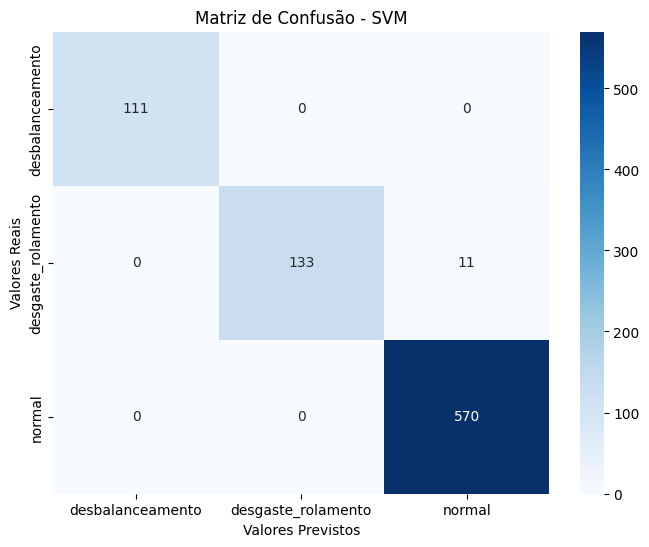

In [ ]:
# 5.2. Modelo de classificação - SVM
print("\nModelagem de classificação (tipo de falha)")
svm_model = SVC(kernel='linear', random_state=42, class_weight='balanced', probability=True)
svm_model.fit(X_train_scaled, y_train_class)
y_pred_svm = svm_model.predict(X_test_scaled)

# Avaliação
accuracy_svm = accuracy_score(y_test_class, y_pred_svm)
print(f"Acurácia - SVM: {accuracy_svm:.2f}")
print("\nRelatório de classificação (SVM):")
print(classification_report(y_test_class, y_pred_svm, target_names=le.classes_))

# Matriz de Confusão
cm_svm = confusion_matrix(y_test_class, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de confusão - SVM')
plt.ylabel('Valores reais')
plt.xlabel('Valores previstos')
plt.show()

## 6. Salvando os artefatos para produção

In [ ]:
# 6.1. Salvando os modelos, o scaler e o label encoder
print("Salvando os artefatos finais...")

# Salvar modelos
dump(rf_reg_model, 'random_forest_regressor_model.joblib')
dump(svm_model, 'svm_model.joblib')
print("Modelos salvos.")

# Salvar scaler
dump(scaler, 'scaler.joblib')
print("Scaler salvo.")

# Salvar label encoder
dump(le, 'label_encoder.joblib')
print("Label Encoder salvo.")

Salvando os artefatos finais...
Modelos salvos.
Scaler salvo.
Label Encoder salvo.

Para baixar os arquivos, execute o código em uma nova célula:
files.download('random_forest_regressor_model.joblib')
files.download('svm_model.joblib')
files.download('scaler.joblib')
files.download('label_encoder.joblib')


In [ ]:
# 6.2. Baixar arquivos
files.download('random_forest_regressor_model.joblib')
files.download('svm_model.joblib')
files.download('scaler.joblib')
files.download('label_encoder.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>